# GSoC Phase 1 Raster Interface Progress

This notebook will give an overview of the newly added functionality for Raster Interface

Till now the focus was mainly on finalizing the API's of different methods to support building weights from `xarray.DataArray` and to go back from `W` object to `xarray.DataArray` 

In [1]:
%matplotlib inline

from libpysal.weights import Rook, Queen, KNN
import numpy as np
import xarray as xr
from esda import Moran_Local

/data/GSoC/libpysal/libpysal/weights/util.py:20: UserWarning: geopandas not available. Some functionality will be disabled.
  warn('geopandas not available. Some functionality will be disabled.')


In [ ]:
!wget https://geographicdata.science/book/data/nasadem/nasadem_sd.tif

Right now only `xarray.DataArray` is supported, therefore we'll use `open_rasterio`method to access the raster. Since the this method is built on top of `rasterio` hence file type compatibilty of this method is similar to that of `rasterio`. 

In [2]:
# Multiband band raster data with no missing values
da1 = xr.open_rasterio('nasadem_sd.tif')
# Slicing the dataarray
da1 = da1[:, 0:100, 350:400]

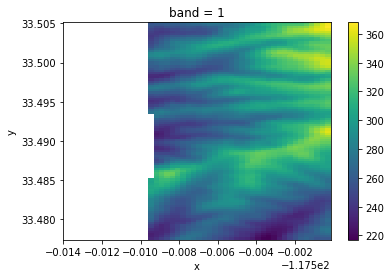

In [3]:
# ploting dataarray after removing missing values
da1.where(da1.data>0).plot()

We can use `from_xarray` method from the contiguity classes like `Rook` and `Queen`, and also from `KNN`.

This uses a util function in raster file called `da2W`, which can also be called directly to build `W` object, similarly `da2WSP` for building `WSP` object

In [4]:
# Let's check the method first
help(Rook.from_xarray)

Help on method from_xarray in module libpysal.weights.contiguity:

from_xarray(da, band=None, sparse=False, **kwargs) method of builtins.type instance
    Construct a W object from a xarray.DataArray object.
    
    Parameters
    ----------
    da         : xarray.DataArray
                raster file accessed using xarray.open_rasterio method
    band       : int
                select band for raster with multiple bands
    sparse     : boolean
                type of weight object. Default is dense. For sparse, sparse = True
    **kwargs   : keyword arguments
                optional arguments for :class:`pysal.weights.W`
    See Also
    --------
    :class:`libpysal.weights.weights.W`



One of the main discussion was _what to store from DataArray_ and _in which attribute to to store the data_.

Initially we planned to store the _non missing data indices we get when we convert `DataArray` to `pd.Series`_ to **`id_order`** but it was later realized that we cannot modify `id_order` for several reasons one of them being that it is used to iterate over weight object in several functions.

Right now I'm adding two attributes _`coords` which stores the indices as mentioned above_ and _`attrs` for storing some metadata of the `DataArray`_ as this will be used when going back to the reverse direction (building DataArray from `W` object).

What are your suggestions regarding this, we'll see how both the attributes are being used.

In [5]:
# function used in from_xarray method
def da2W(da, criterion, **kwargs):
    """
    Create a W object from rasters(xarray.DataArray)

    Parameters
    ----------
    da         : xarray.DataArray
                 raster file accessed using xarray.open_rasterio method
    criterion  : {"rook", "queen"}
                 option for which kind of contiguity to build
    Returns
    -------
    w    : libpysal.weights.W
           instance of spatial weights class W
    """
    if criterion != 'rook':
        rook = False
    else:
        rook = True
    w = lat2W(*da[0].shape, rook, **kwargs)
    ser = da.to_series()
    id_order = np.where(ser != da.nodatavals[0])[0]
    w = w_subset(w, id_order)
    ser = ser[ser != da.nodatavals[0]]
    w.coords = ser.index
    attrs = da.attrs
    attrs["dims"] = da.dims
    attrs["shape"] = da.shape
    w.attrs = attrs
    return w

In [6]:
# for creating WSP object from DataArray
def da2SW(da, criterion, **kwargs):
    """
    Generate a WSP object from rasters(xarray.DataArray)

    Parameters
    ----------
    da         : xarray.DataArray
                 raster file accessed using xarray.open_rasterio method
    criterion  : {"rook", "queen"}
                 option for which kind of contiguity to build
    Returns
    -------
    sw    : libpysal.weights.WSP
           instance of spatial weights class WSP
    """
    sw = lat2SW(*da[0].shape, criterion)
    ser = da.to_series()
    id_order = np.where(ser != da.nodatavals[0])[0]
    indices = np.where(ser == da.nodatavals[0])[0]
    mask = np.ones((sw.shape[0],), dtype=np.bool)
    mask[indices] = False
    for _ in range(2):
        sw = sw[mask]
        sw = sw.transpose()
        sw = sw.tocsr()
    sw = WSP(sw)
    sw.id_order = id_order
    ser = ser[ser != da.nodatavals[0]]
    sw.coords = ser.index
    attrs = da.attrs
    attrs["dims"] = da.dims
    attrs["shape"] = da.shape
    sw.attrs = attrs
    return sw

In [7]:
# Creating weight of object from raster
w_rook = Rook.from_xarray(da1)

Lets check the new attributes added to the `W` object 

In [8]:
# attrs contains the metadata of DataArray 
w_rook.attrs

{'transform': (0.0002777777777777778,
  0.0,
  -117.61125,
  0.0,
  -0.0002777777777777778,
  33.505138888888894),
 'crs': '+init=epsg:4326',
 'res': (0.0002777777777777778, 0.0002777777777777778),
 'is_tiled': 0,
 'nodatavals': (-32768.0,),
 'scales': (1.0,),
 'offsets': (0.0,),
 'AREA_OR_POINT': 'Area',
 'dims': ('band', 'y', 'x'),
 'shape': (1, 100, 50)}

In [9]:
# coords contains the multi-indices of non-missing data values 
w_rook.coords[:5]

MultiIndex([(1, 33.505, -117.50944444444444),
            (1, 33.505, -117.50916666666666),
            (1, 33.505, -117.50888888888889),
            (1, 33.505, -117.50861111111111),
            (1, 33.505, -117.50833333333333)],
           names=['band', 'y', 'x'])

Here we first convert the `DataArray` to `Series` and then use the indices from `coords` attribute to remove missing values by subsetting the `Series` 

In [10]:
# Loading the raster data for further calculation
data1 = da1.to_series()[w_rook.coords]
data1[:5]

band  y       x          
1     33.505  -117.509444    256
              -117.509167    261
              -117.508889    263
              -117.508611    263
              -117.508333    264
dtype: int16

In [11]:
# Quickly computing and loading a LISA
np.random.seed(12345)
lisa = Moran_Local(data1,w_rook)

`to_xarray` is an instance method of `W` object which converts the `W` object back to `DataArray`, we can also use `w2da` function directly to do the same.

In [12]:
# Let's check the method first
help(w_rook.to_xarray)

Help on method to_xarray in module libpysal.weights.weights:

to_xarray(data, coords=None) method of libpysal.weights.weights.W instance
    converts calculated results to ``xarray.DataArray`` object
    
    Arguments
    ---------
    data    :   array
                data values stored in 1d array
    coords  :   Dictionary/xarray.core.coordinates.DataArrayCoordinates
                coordinates from original DataArray
    Returns
    -------
    
    da : xarray.DataArray
        instance of xarray.DataArray



In [13]:
# here we can see how `attrs` is being utilized
def w2da(data, w, coords=None):
    """
    converts calculated results to a DataArray

    Arguments
    ---------
    data    :   array
                data values stored in 1d array
    w       :   W object
                weight object obtained from DataArray
    coords  :   Dictionary/xarray.core.coordinates.DataArrayCoordinates
                coordinates from original DataArray
    Returns
    -------

    da : xarray.DataArray
         instance of xarray.DataArray
    """
    attrs = w.attrs
    dims = attrs.pop('dims')
    shape = attrs.pop('shape')
    if coords is not None:
        shape = tuple(len(value) for value in coords.values())
        dims = tuple(key for key in coords.keys())
    else:
        coords = {}
        nx, ny = shape[2], shape[1]
        transform = Affine(*attrs["transform"])
        x, _ = transform * (np.arange(nx) + 0.5, np.zeros(nx) + 0.5)
        _, y = transform * (np.zeros(ny) + 0.5, np.arange(ny) + 0.5)
        coords["band"] = np.ones(1)
        coords["y"] = y
        coords["x"] = x
    ser = pd.Series(data, index=w.id_order)
    n = shape[1]*shape[2]
    ser = ser.reindex(index=range(n), fill_value=attrs['nodatavals'][0])
    data = ser.to_numpy().reshape((shape))
    da = DataArray(data=data, dims=dims, coords=coords, attrs=attrs)
    return da

In [14]:
# Converting obtained data back to DataArray
moran_da1 = w_rook.to_xarray(lisa.p_sim)

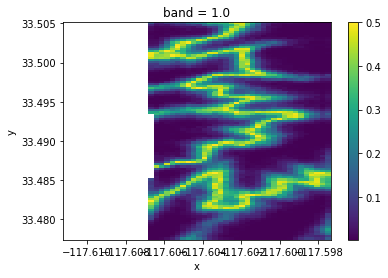

In [15]:
# Plotting the converted DataArray
moran_da1.where(moran_da1.data>0).plot()

Lets create distance weights from `DataArray`

In [16]:
# Multiband band raster data with no missing values
da1 = xr.open_rasterio('nasadem_sd.tif')
# Slicing the dataarray
da1 = da1[:, 0:100, 350:400]

In [17]:
# Uses coordinates of each pixel to determine nearest neighbor
w_knn = KNN.from_xarray(da1, k=2)

/data/GSoC/libpysal/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 364 disconnected components.
  warnings.warn(message)
/data/GSoC/libpysal/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 253 disconnected components.
 There is 1 island with id: 2066.
  warnings.warn(message)


In [20]:
w_knn.histogram

[(0, 1), (1, 22), (2, 3347)]

Since the API part is almost over, I've started working on the optimization part:
- creating weights object directly from non-missing values
- involving Numba into existing methods for speeding up the creation

**What do you guys think regarding current API and the attribute situation?**

Once this is completed I can finish up the tests and add docstring examples